In [173]:
from caveclient import CAVEclient, auth
from caveclient import chunkedgraph as cg
import datetime
from itertools import accumulate

In [163]:
url = "https://local.brain-wire-test.org"
global_url = "https://global.brain-wire-test.org/"
datastack = "h01_c3_flat"
dataset = "h01_full0_v2"

In [164]:
client = CAVEclient(datastack_name=datastack, server_address=global_url)

### Get all user IDs

In [165]:
usr_list = client.auth.get_group_users(group_id=1) # get all users in the default group
ids = [item['id'] for item in usr_list]

print(ids)

[1, 4, 5, 8, 9, 10, 12, 14, 15, 16, 18, 19, 20, 21, 22, 23, 26, 27, 28, 30, 31, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 51, 52, 53, 54, 56, 57, 46, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]


In [166]:
def evenly_spaced_timestamps(start_date, end_date, n):
    time_diff_seconds = (end_date - start_date).total_seconds()
    interval_seconds = time_diff_seconds / (n - 1)
    timestamps = [int(start_date.timestamp()) + i * interval_seconds for i in range(n)]
    return [datetime.datetime.fromtimestamp(val) for val in timestamps]

### Iterate over all users and count number of edits


In [182]:
cggraph = cg.ChunkedGraphClient(server_address=url, table_name=dataset, auth_client=auth.AuthClient(token=client.auth.token))

start = datetime.datetime(2022, 1, 1)
end = datetime.datetime.now()
interval = 15

total_edits = []
timestamps = evenly_spaced_timestamps(start, end, interval)

for timestamp in timestamps[1:]:
    edits = 0
    for user_id in ids:
        operations = cggraph.get_user_operations(user_id=user_id, timestamp_start=start, timestamp_end=timestamp)
        edits += len(operations)
    total_edits.append(edits)
    start = timestamp

cumulative = list(accumulate(total_edits))

print("Total edits: " + str(total_edits))
print("Cumulative edits: " + str(cumulative))

Total edits: [0, 0, 0, 0, 1221, 2224, 2207, 1445, 772, 3215, 7295, 429, 1541, 1501]
Cumulative edits: [0, 0, 0, 0, 1221, 3445, 5652, 7097, 7869, 11084, 18379, 18808, 20349, 21850]


### Plot Results as Line Chart

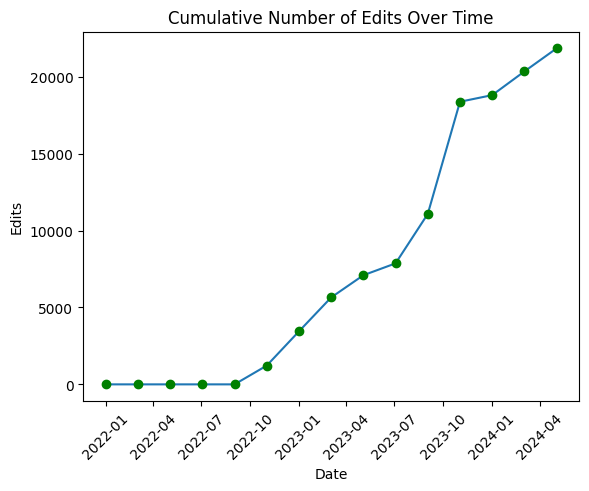

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({'Date': timestamps, 'Edits': [0] + cumulative})
sns.lineplot(data=df, x='Date', y='Edits')
plt.plot(timestamps, [0] + cumulative, 'go')
plt.xticks(rotation=45)
plt.title('Cumulative Number of Edits Over Time')
plt.show()